In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import cv2
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import random

from IPython.display import HTML
from pathlib import Path
from PIL import Image

from loader import DataLoader
from models.spectral_model import get_inferred_image
from registration.first_registration import Align
from registration.reg_c import RegC
from registration.reg_d import RegD
from models.ransacflow import register_image

DATA_DIR = "/Users/farhanoktavian/imperial/thesis/sandbox/dataset/raw"
METADATA_DIR = "/Users/farhanoktavian/imperial/thesis/sandbox/dataset/data.h5"
SAVE_DIR = "/Users/farhanoktavian/imperial/thesis/sandbox/rf_regist/images"

Loaded pretrained model from /Users/farhanoktavian/imperial/thesis/sandbox/rf_regist/weights/MegaDepth_Theta1_Eta001_Grad1_0.774.pth


In [2]:
run_loader = DataLoader(DATA_DIR, METADATA_DIR)

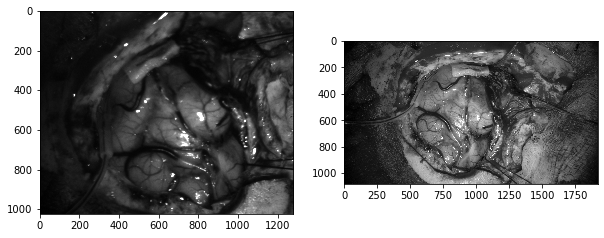

HS005 - Run07


In [3]:
# Get run randomly
# sample = random.choice(run_loader.samples)
# run = random.choice(sample.runs)
sample = run_loader.samples[4]
run = sample.runs[2]

run_coll = random.randint(0, run.collection_count - 1)
SI = run.get_spectral_image(wavelength=600, collection_idx=run_coll)
MI = run.get_label_image(channel="bw")

# Plot SI and MI side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(SI, cmap="gray")
ax[1].imshow(MI, cmap="gray")
plt.show()

print(f"{run.sample_id} - {run.run_id}")

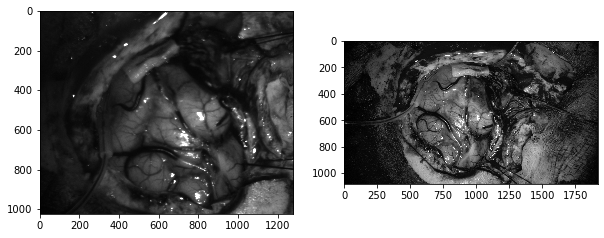

In [4]:
# Get images
SI_image = run.get_spectral_image(wavelength=600)
MI_image = run.get_label_image(channel="g")

# Plot SI and MI side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(SI_image, cmap="gray", vmin=0, vmax=255)
ax[1].imshow(MI_image, cmap="gray", vmin=0, vmax=255)
plt.show()


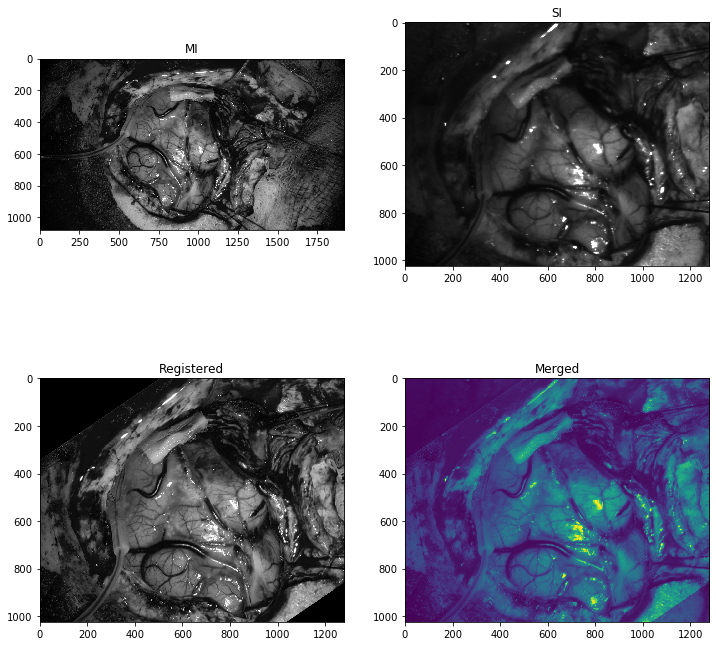

In [5]:
# Rough alignment
align = Align(MI_image, SI_image, mode="sift", threshold=1)
reg_img, merg_img = align.align_image()

fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax[0][0].title.set_text("MI")
ax[0][1].title.set_text("SI")
ax[1][0].title.set_text("Registered")
ax[1][1].title.set_text("Merged")

ax[0][0].imshow(MI_image, cmap="gray", vmin=0, vmax=255)
ax[0][1].imshow(SI_image, cmap="gray", vmin=0, vmax=255)
ax[1][0].imshow(reg_img, cmap="gray", vmin=0, vmax=255)
ax[1][1].imshow(merg_img)
plt.show()

In [8]:
# Fine alignment
temp_reg = cv2.merge([reg_img, reg_img, reg_img])
temp_si = cv2.merge([SI_image, SI_image, SI_image])
reg_a =  register_image(Image.fromarray(temp_reg), Image.fromarray(temp_si))
reg_a = reg_a[:,:,0]

h, w = reg_a.shape

regD = RegD()
reg_b = regD.register(reg_img, SI_image)
reg_b = cv2.resize(reg_b, (w, h))

reg_img_pad = np.zeros((reg_img.shape))
reg_img_pad[reg_img == 0] = reg_img[reg_img == 0]
reg_b_pad = regD.register(reg_img_pad, SI_image)
reg_b_pad = cv2.resize(reg_b_pad, (w, h))

regC = RegC()
reg_c = regC.register(reg_img, SI_image)
reg_c = cv2.resize(reg_c, (w, h))

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(reg_a, cmap="gray", vmin=0, vmax=255)
ax[1].imshow(reg_b, cmap="gray", vmin=0, vmax=255)
plt.show()

error: OpenCV(4.7.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/histogram.cpp:3440: error: (-215:Assertion failed) _src.type() == CV_8UC1 in function 'equalizeHist'


In [ ]:
resized_SI = cv2.resize(SI_image, (w, h))
# img_to_save = [("raw", resized_SI), ("mi", cv2.resize(reg_img, (w, h))), ("rf", reg_a), ("bspl", reg_b), ("disp", reg_c)]
img_to_save = [("bsplpad", reg_b_pad)]

for ty, img in img_to_save:
    img_path = Path(f"{SAVE_DIR}/{run.sample_id}/{run.run_id}-{ty}.png")
    # Create path if not exist
    img_path.parent.mkdir(parents=True, exist_ok=True)
    cv2.imwrite(str(img_path), img)

NameError: name 'reg_b_pad' is not defined